# Assistant
The error you're encountering indicates that the TensorFlow library is not installed in your current Python environment. This means that when you try to import TensorFlow, Python cannot find it.

To fix this error, you need to install TensorFlow. You can do this using pip. If you're using a Jupyter Notebook, you can run the following command in a code cell:



Would you like me to provide the complete installation command?

In [5]:
!pip install tensorflow

In [43]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [45]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [47]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [49]:
class_names = dataset.class_names
class_names

['Potato__Early_blight', 'Potato__Late_blight', 'Potato__healthy']

In [51]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


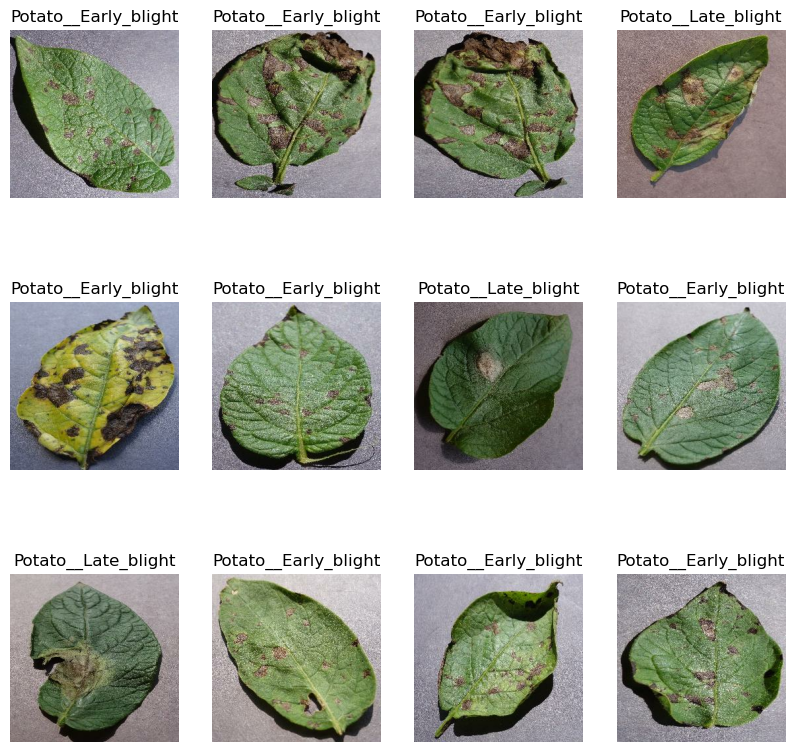

In [53]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [54]:
len(dataset)

68

In [55]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [57]:
train_ds = dataset.take(54)
len(train_ds)

54

In [61]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [63]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [65]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [67]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [69]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [71]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [73]:
len(train_ds)

54

In [75]:
len(val_ds)

6

In [77]:
len(test_ds)

8

In [79]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [83]:
# Create a Sequential model with resizing and rescaling layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Removed 'experimental' prefix
    layers.Rescaling(1./255),  # Removed 'experimental' prefix
])

In [87]:
# Create a Sequential model for data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Removed 'experimental' prefix
    layers.RandomRotation(0.2),                     # Removed 'experimental' prefix
])

In [89]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [99]:
resize_and_rescale = layers.Rescaling(1./255)  # Example of a preprocessing layer

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [101]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [117]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 797ms/step - accuracy: 0.9165 - loss: 0.2038 - val_accuracy: 0.9323 - val_loss: 0.1886
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 796ms/step - accuracy: 0.9219 - loss: 0.1929 - val_accuracy: 0.9010 - val_loss: 0.2376
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 750ms/step - accuracy: 0.9206 - loss: 0.2030 - val_accuracy: 0.9375 - val_loss: 0.1451
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 780ms/step - accuracy: 0.9256 - loss: 0.1632 - val_accuracy: 0.8750 - val_loss: 0.3609
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 792ms/step - accuracy: 0.9177 - loss: 0.2132 - val_accuracy: 0.9219 - val_loss: 0.2020
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.9206 - loss: 0.2053 - val_accuracy: 0.9062 - val_loss: 0.1702
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 749ms/step - accuracy: 0.9480 - loss: 0.1355 - val_accuracy: 0.9635 - val_loss: 0.0917
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 800ms/step - accuracy: 0.9670 - loss: 0.0993 - val_accu

In [118]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 428ms/step - accuracy: 0.9756 - loss: 0.1125


In [119]:
scores

[0.12954021990299225, 0.97265625]

In [120]:
history

In [121]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [122]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [123]:
type(history.history['loss'])

list

In [124]:
len(history.history['loss'])

50

In [125]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.21058368682861328,
 0.21619398891925812,
 0.1960124969482422,
 0.15745674073696136,
 0.17829629778862]

In [126]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

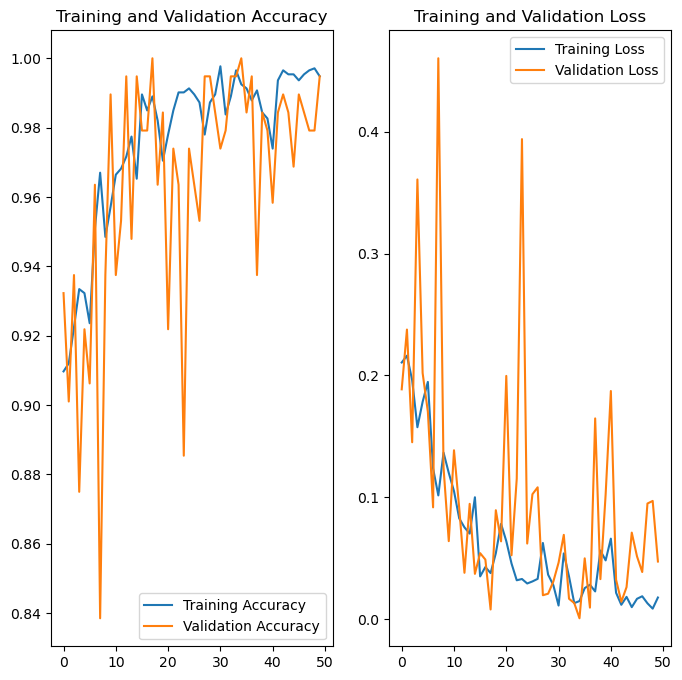

In [127]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato__Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
predicted label: Potato__Late_blight


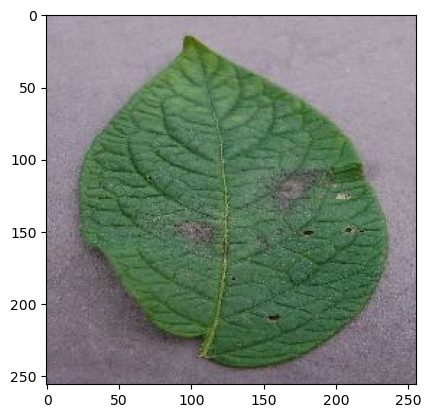

In [128]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [129]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


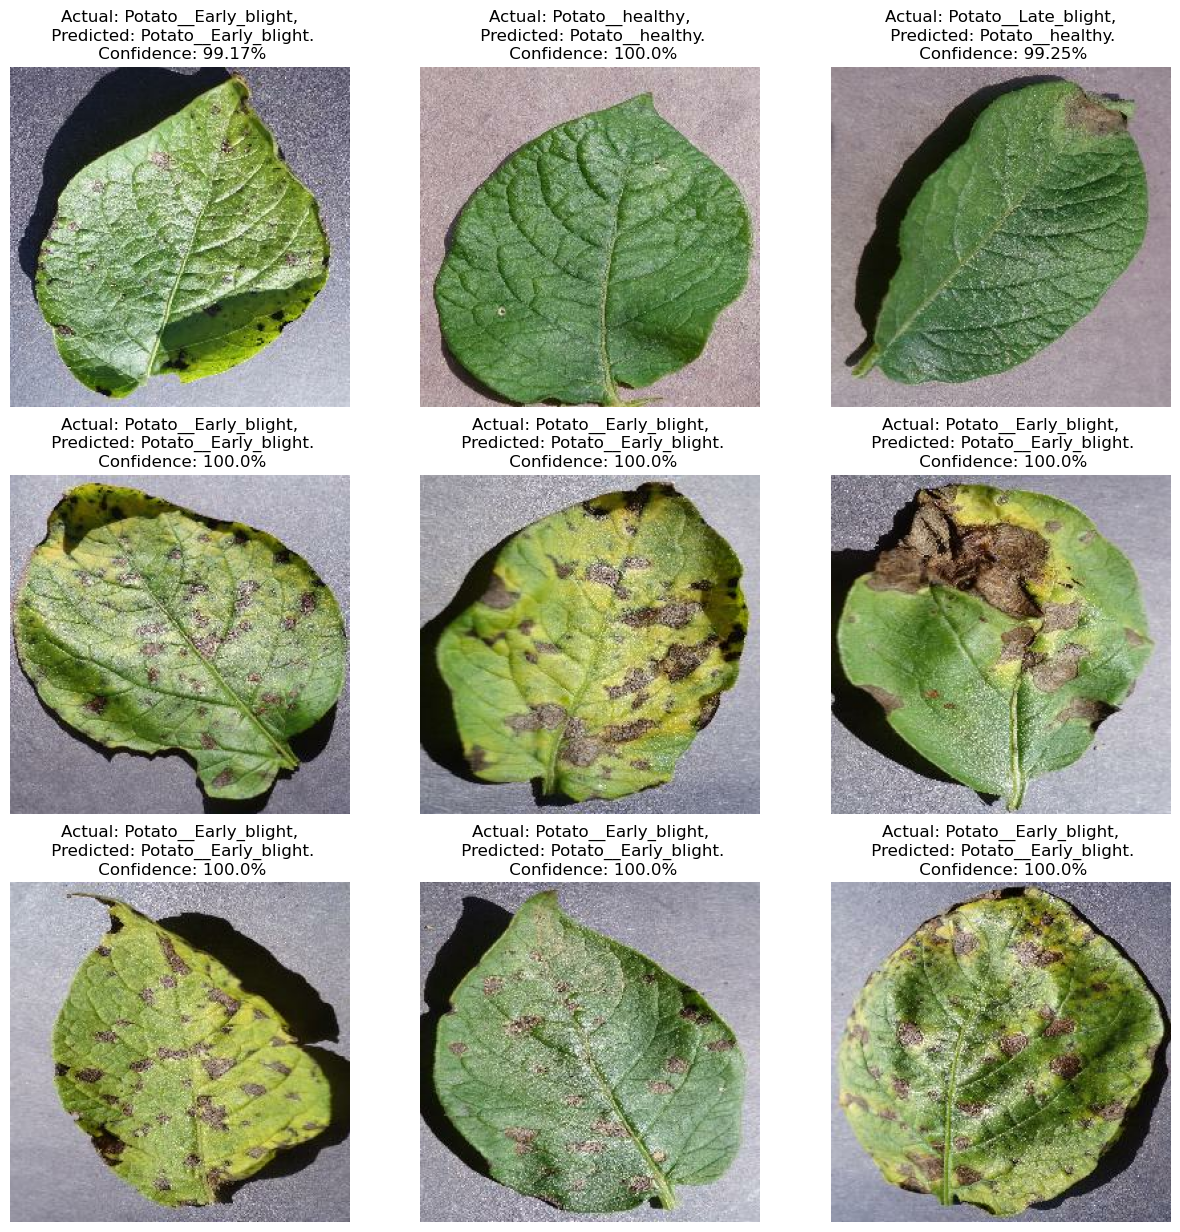

In [130]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")